# Problema 5: Rutas Óptimas para Equipos de Inspección de Infraestructura en Colombia
## 1. Conjuntos
- $N$ para los nodos/localidades a visitar, donde $N = \{0, 1, 2, \dots, n\}$. El nodo $0$ es la localidad base (punto de partida y llegada).
- $K$ para los equipos de inspección, donde $K = \{1, 2, \dots, m\}$.
## 2. Parámetros
$C$, una matriz con los costos entre las localidades. Cada elemento $c_{ij}$ indica el costo entre el nodo $i$ y el nodo $j$.
$m$, el número de equipos de inspección.
## 3. Variables de decisión
- $x_{ijk}$ binaria, donde $1$ indica que el equipo $k$ viaja de la localidad $i$ a la localidad $j$, y $0$ en el caso contrario.
- $u_ik$ entera, que representa el orden en el que el equipo $k$ visita la localidad $i$. Se utiliza para eliminar subtours.
## 4. Función objetivo
Minimizar el costo total de los viajes de todos los equipos: $min\sum_{k \in K}\sum_{i \in N}\sum_{j \in N} c_{ij}x_{ijk}$.
## 5. Restricciones
#### 1. Cada nodo a excepción del nodo 1 debe tener una arista de llegada
$\sum_{i \in N | i \neq j} \sum_{k \in K} x_{ijk} = 1 \quad \forall j \in N | j \neq 0$

#### 2. Cada nodo a excepción del nodo 1 debe tener una arista de salida
$\sum_{j \in N | j \neq i} \sum_{k \in K} x_{ijk} = 1 \quad \forall i \in N | i \neq 0$
#### 3. Cada equipo sale de la localidad 0
$\sum_{j \in N | \forall j \neq 0} x_{0jk} = 1 \quad \forall k \in K$.
#### 4. Cada equipo regresa a la localidad 0
$\sum_{j \in N | \forall j \neq 0} x_{0jk} = 1 \quad \forall k \in K$.
 #### 5. Eliminación de subtours
 $\sum_{k \in K} (u_ik - u_jk + (|N| - 1) \cdot x_{ijk}) \leq |N| - 2 \quad \forall i, j \in N | j \neq 0, i \neq j$.
 - definiendo el rango: $\sum_{k \in K} (1 \leq u_ik \leq |N| - 1) \quad \forall i \in N | i \neq 0$.
#### 6. No se permite viajar de un nodo a sí mismo
$x_{iik} = 0 \quad \forall i \in N, \forall k \in K$. 
 #### 7. Flujo de cada equipo: cada equipo que llega a un nodo, debe salir de él
 $\sum_{i \in N | i \neq j} x_{ijk} = \sum_{i \in N | i \neq j} x_{jik} \quad \forall j \in N \setminus \{0\}, \forall k \in K$.

## 6. Tipo de problema
MIP, pues las variables $x_{ijk}$ son binarias, las variables $u_ik$ son enteras, y la función objetivo y las restricciones son lineales.

In [1]:
import pandas as pd
import csv
import numpy as np
def read_cost_matrix_csv(filename):
    """
    Reads a cost matrix from a CSV file and returns it as a numpy array.
    
    The first row of the CSV is assumed to contain the node IDs.
    
    Parameters:
        filename (str): Name of the input CSV file.
    
    Returns:
        numpy.ndarray: The cost matrix read from the file.
    """
    with open(filename, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        # Read the first row to get the node IDs.
        node_ids = next(reader)
        # Read the remaining rows as data.
        data = list(reader)
    
    # Convert the data to a numpy array.
    cost_matrix = np.array(data, dtype=int)
    
    return cost_matrix


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pyomo.environ as pyo

def plot_solution(model, N, K):
    """
    Plots the solution as a directed graph using NetworkX and matplotlib.
    Since there's only one route (single driver), all edges are colored the same.
    """
    valid_edges = []
    for i in N:
        for j in N:
            for k in K:
                if pyo.value(model.x[i, j,k]) > 0.5:
                    valid_edges.append((i, j))

    # Build a directed graph
    G = nx.DiGraph()
    G.add_nodes_from(N)

    # Add edges from the solution
    for (i, j) in valid_edges:
        G.add_edge(i, j)

    pos = nx.spring_layout(G)
    nx.draw_networkx(G, pos, with_labels=True,
                     node_color='lightblue',
                     edge_color='red',
                     arrows=True)
    plt.axis("off")
    plt.show()

In [3]:
from __future__ import division
from pyomo.environ import *
from pyomo.opt import SolverFactory
import sys
import os

def salesman(cost, numeroEquipos):
    numNodes = cost.shape[0]
    Model = ConcreteModel()
    # SETS & PARAMETERS********************************************************************
    N=RangeSet(1, numNodes)
    K = RangeSet(1, numeroEquipos)

    # VARIABLES****************************************************************************
    Model.x = Var(N,N,K, domain=Binary)

    Model.u = Var(N,K,bounds=(1,numNodes-1), domain=NonNegativeIntegers) 


    # OBJECTIVE FUNCTION*******************************************************************
    Model.obj = Objective( expr=sum(Model.x[i, j, k] * cost[i - 1, j - 1] for i in N for j in N for k in K if i != j),sense=minimize)

    # CONSTRAINTS**************************************************************************

    # Restricción 1: Cada nodo a excepción del nodo 1 debe tener una arista de llegada
    Model.res1 = ConstraintList()
    for j in N:
        if j != 1:
            Model.res1.add(sum(Model.x[i, j, k] for i in N if i != j for k in K) == 1)

    # Restriccion 2: Cada nodo a excepción del nodo 1 debe tener una arista de salida
    Model.res2 = ConstraintList()   
    for i in N:
        if i != 1:
            Model.res2.add(sum(Model.x[i, j, k] for j in N if i != j for k in K) == 1)

    # Restriccion 3: Cada equipo debe salir del nodo 1
    Model.res3=ConstraintList()
    for k in K:
        Model.res3.add(sum(Model.x[1, j, k] for j in N if j != 1) == 1)
    
    # Restriccion 4: Cada equipo debe llegar al nodo 1
    Model.res4=ConstraintList()
    for k in K:
        Model.res4.add(sum(Model.x[i, 1, k] for i in N if i != 1) == 1)

    # Restriccion 5: Subtours
    Model.res5 = ConstraintList()
    for i in N:
        for j in N:
            for k in K:
                if i != j and i != 1 and j != 1:
                    Model.res5.add(
                        Model.u[i, k] - Model.u[j, k] + (numNodes - 1) * Model.x[i, j, k] <= numNodes - 2)

    # Restricción 6: no se puede viajar de un nodo a sí mismo
    Model.res6 = ConstraintList()
    for i in N:
        for k in K:
            Model.res6.add(Model.x[i, i, k] == 0)

    # Flujo de cada equipo: cada equipo que llega a un nodo, debe salir de él
    Model.res7 = ConstraintList()
    for k in K:
        for j in N:
            if j != 1:
                Model.res7.add(sum(Model.x[i, j, k] for i in N if i != j) - sum(Model.x[j, i, k] for i in N if i != j) == 0)

    # APPLYING THE SOLVER******************************************************************
    SolverFactory('glpk').solve(Model)

    Model.display()

    # Verificar que cada equipo salga y llegue al nodo 1
    for k in K:
        salida = sum(Model.x[1, j, k].value for j in N if j != 1)
        llegada = sum(Model.x[i, 1, k].value for i in N if i != 1)
        print(f"Equipo {k}: Salida del nodo 1 = {salida}, Llegada al nodo 1 = {llegada}")
    
    #imprimir los nodos de cada6 equipo
    for k in K:
        print(f"Equipo {k}:")
        for i in N:
            for j in N:
                if Model.x[i, j, k].value == 1:
                    print(f"De {i} a {j}")

    #imprimir los costos de cada equipo
    for k in K:
        costo = sum(Model.x[i, j, k].value * cost[i - 1, j - 1] for i in N for j in N if i != j)
        print(f"Costo del equipo {k}: {costo}")             

    return Model, N, K

cost = read_cost_matrix_csv('datosTSP\cost_matrix_5_nodes_2.5_spread.csv')


os.system("clear")


1

Correr el caso de 5 nodos, con 1 2 y 3 equipos

--------------------Solución para k = 1----------------------
Model unknown

  Variables:
    x : Size=25, Index=[1:5]*[1:5]*[1]
        Key       : Lower : Value : Upper : Fixed : Stale : Domain
        (1, 1, 1) :     0 :   0.0 :     1 : False : False : Binary
        (1, 2, 1) :     0 :   0.0 :     1 : False : False : Binary
        (1, 3, 1) :     0 :   0.0 :     1 : False : False : Binary
        (1, 4, 1) :     0 :   0.0 :     1 : False : False : Binary
        (1, 5, 1) :     0 :   1.0 :     1 : False : False : Binary
        (2, 1, 1) :     0 :   0.0 :     1 : False : False : Binary
        (2, 2, 1) :     0 :   0.0 :     1 : False : False : Binary
        (2, 3, 1) :     0 :   0.0 :     1 : False : False : Binary
        (2, 4, 1) :     0 :   1.0 :     1 : False : False : Binary
        (2, 5, 1) :     0 :   0.0 :     1 : False : False : Binary
        (3, 1, 1) :     0 :   0.0 :     1 : False : False : Binary
        (3, 2, 1) :     0 :   1.0 :     1 : False : False : Binary


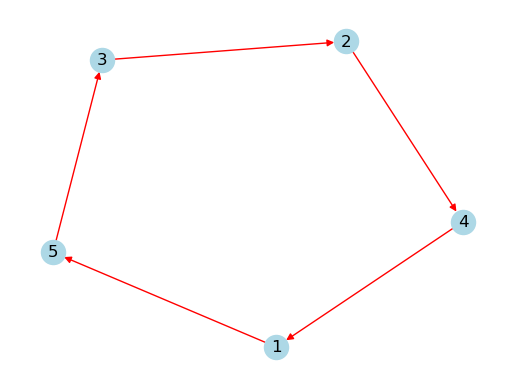

--------------------Solución para k = 2----------------------
Model unknown

  Variables:
    x : Size=50, Index=[1:5]*[1:5]*[1:2]
        Key       : Lower : Value : Upper : Fixed : Stale : Domain
        (1, 1, 1) :     0 :   0.0 :     1 : False : False : Binary
        (1, 1, 2) :     0 :   0.0 :     1 : False : False : Binary
        (1, 2, 1) :     0 :   0.0 :     1 : False : False : Binary
        (1, 2, 2) :     0 :   0.0 :     1 : False : False : Binary
        (1, 3, 1) :     0 :   1.0 :     1 : False : False : Binary
        (1, 3, 2) :     0 :   0.0 :     1 : False : False : Binary
        (1, 4, 1) :     0 :   0.0 :     1 : False : False : Binary
        (1, 4, 2) :     0 :   0.0 :     1 : False : False : Binary
        (1, 5, 1) :     0 :   0.0 :     1 : False : False : Binary
        (1, 5, 2) :     0 :   1.0 :     1 : False : False : Binary
        (2, 1, 1) :     0 :   0.0 :     1 : False : False : Binary
        (2, 1, 2) :     0 :   0.0 :     1 : False : False : Binar

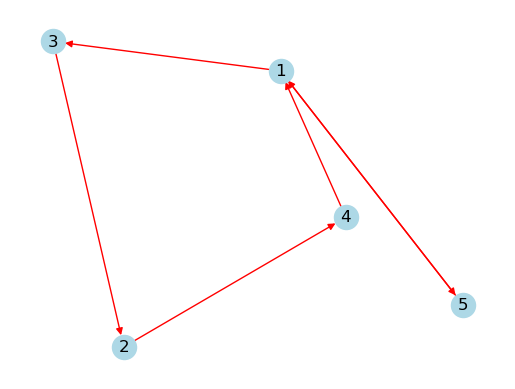

--------------------Solución para k = 3----------------------
Model unknown

  Variables:
    x : Size=75, Index=[1:5]*[1:5]*[1:3]
        Key       : Lower : Value : Upper : Fixed : Stale : Domain
        (1, 1, 1) :     0 :   0.0 :     1 : False : False : Binary
        (1, 1, 2) :     0 :   0.0 :     1 : False : False : Binary
        (1, 1, 3) :     0 :   0.0 :     1 : False : False : Binary
        (1, 2, 1) :     0 :   1.0 :     1 : False : False : Binary
        (1, 2, 2) :     0 :   0.0 :     1 : False : False : Binary
        (1, 2, 3) :     0 :   0.0 :     1 : False : False : Binary
        (1, 3, 1) :     0 :   0.0 :     1 : False : False : Binary
        (1, 3, 2) :     0 :   0.0 :     1 : False : False : Binary
        (1, 3, 3) :     0 :   1.0 :     1 : False : False : Binary
        (1, 4, 1) :     0 :   0.0 :     1 : False : False : Binary
        (1, 4, 2) :     0 :   0.0 :     1 : False : False : Binary
        (1, 4, 3) :     0 :   0.0 :     1 : False : False : Binar

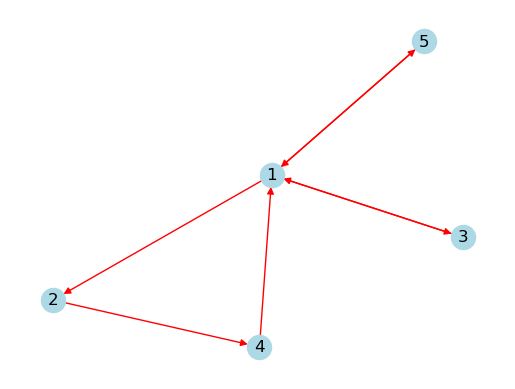

Ejecutando caso de prueba con datosTSP\cost_matrix_5_nodes_2.5_spread.csv...


In [4]:
# ejecutar el caso de prueba para k=1, k=2 y k=3
def ejecutar_con_distintos_k(filename):
    for k in [1, 2, 3]:
        cost_matrix = read_cost_matrix_csv(filename)
        print(f"--------------------Solución para k = {k}----------------------")
        Model, N, K= salesman(cost_matrix, k)
        plot_solution(Model, N, K)
    
for archivo in ["datosTSP\cost_matrix_5_nodes_2.5_spread.csv"]:
    ejecutar_con_distintos_k(archivo)
    print(f'Ejecutando caso de prueba con {archivo}...') 

Correr el caso de 10  nodos, con 1, 3, 5 equipos

--------------------Solución para k = 1----------------------


Model unknown

  Variables:
    x : Size=100, Index=[1:10]*[1:10]*[1]
        Key         : Lower : Value : Upper : Fixed : Stale : Domain
          (1, 1, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 2, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 3, 1) :     0 :   1.0 :     1 : False : False : Binary
          (1, 4, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 5, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 6, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 7, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 8, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 9, 1) :     0 :   0.0 :     1 : False : False : Binary
         (1, 10, 1) :     0 :   0.0 :     1 : False : False : Binary
          (2, 1, 1) :     0 :   0.0 :     1 : False : False : Binary
          (2, 2, 1) :     0 :   0.0 :     1 : False : False : Binary
          (2, 3, 1) :     0 :   0

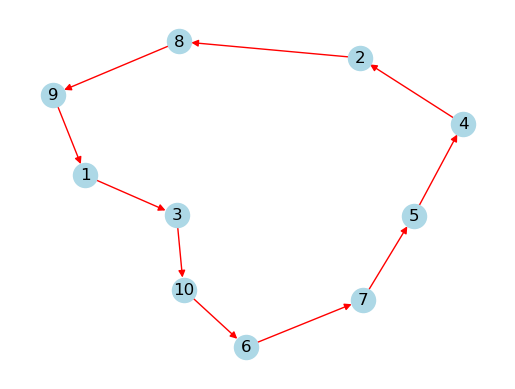

--------------------Solución para k = 3----------------------
Model unknown

  Variables:
    x : Size=300, Index=[1:10]*[1:10]*[1:3]
        Key         : Lower : Value : Upper : Fixed : Stale : Domain
          (1, 1, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 1, 2) :     0 :   0.0 :     1 : False : False : Binary
          (1, 1, 3) :     0 :   0.0 :     1 : False : False : Binary
          (1, 2, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 2, 2) :     0 :   0.0 :     1 : False : False : Binary
          (1, 2, 3) :     0 :   0.0 :     1 : False : False : Binary
          (1, 3, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 3, 2) :     0 :   1.0 :     1 : False : False : Binary
          (1, 3, 3) :     0 :   0.0 :     1 : False : False : Binary
          (1, 4, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 4, 2) :     0 :   0.0 :     1 : False : False : Binary
          (1, 4, 3) :     0 :   0.0 : 

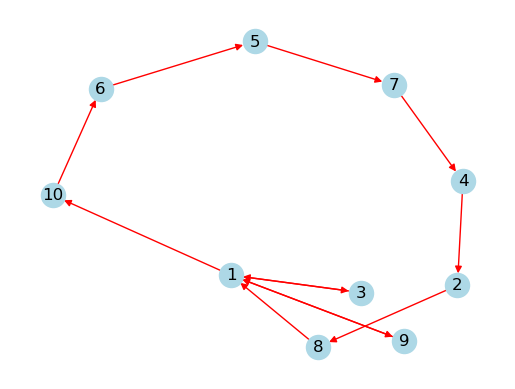

--------------------Solución para k = 5----------------------
Model unknown

  Variables:
    x : Size=500, Index=[1:10]*[1:10]*[1:5]
        Key         : Lower : Value : Upper : Fixed : Stale : Domain
          (1, 1, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 1, 2) :     0 :   0.0 :     1 : False : False : Binary
          (1, 1, 3) :     0 :   0.0 :     1 : False : False : Binary
          (1, 1, 4) :     0 :   0.0 :     1 : False : False : Binary
          (1, 1, 5) :     0 :   0.0 :     1 : False : False : Binary
          (1, 2, 1) :     0 :   1.0 :     1 : False : False : Binary
          (1, 2, 2) :     0 :   0.0 :     1 : False : False : Binary
          (1, 2, 3) :     0 :   0.0 :     1 : False : False : Binary
          (1, 2, 4) :     0 :   0.0 :     1 : False : False : Binary
          (1, 2, 5) :     0 :   0.0 :     1 : False : False : Binary
          (1, 3, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 3, 2) :     0 :   1.0 : 

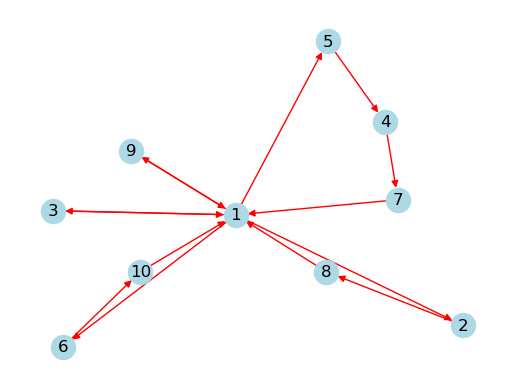

Ejecutando caso de prueba con datosTSP\cost_matrix_10_nodes_1.5_spread.csv...


In [5]:
# ejecutar el caso de prueba para k=1, k=3 y k=5 
def ejecutar_con_distintos_k(filename):
    for k in [1, 3, 5]:
        cost_matrix = read_cost_matrix_csv(filename)
        print(f"--------------------Solución para k = {k}----------------------")
        Model, N, K= salesman(cost_matrix, k)
        plot_solution(Model, N, K)
    
for archivo in [ "datosTSP\cost_matrix_10_nodes_1.5_spread.csv"]:
    ejecutar_con_distintos_k(archivo)
    print(f'Ejecutando caso de prueba con {archivo}...') 

Correr el caso de 15  nodos, con 1, 2 equipos

--------------------Solución para k = 1----------------------


Model unknown

  Variables:
    x : Size=225, Index=[1:15]*[1:15]*[1]
        Key         : Lower : Value : Upper : Fixed : Stale : Domain
          (1, 1, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 2, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 3, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 4, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 5, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 6, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 7, 1) :     0 :   1.0 :     1 : False : False : Binary
          (1, 8, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 9, 1) :     0 :   0.0 :     1 : False : False : Binary
         (1, 10, 1) :     0 :   0.0 :     1 : False : False : Binary
         (1, 11, 1) :     0 :   0.0 :     1 : False : False : Binary
         (1, 12, 1) :     0 :   0.0 :     1 : False : False : Binary
         (1, 13, 1) :     0 :   0

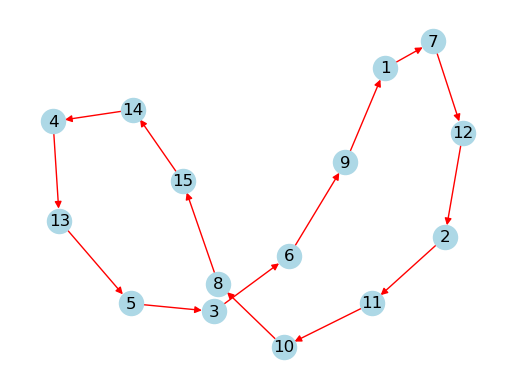

--------------------Solución para k = 2----------------------
Model unknown

  Variables:
    x : Size=450, Index=[1:15]*[1:15]*[1:2]
        Key         : Lower : Value : Upper : Fixed : Stale : Domain
          (1, 1, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 1, 2) :     0 :   0.0 :     1 : False : False : Binary
          (1, 2, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 2, 2) :     0 :   0.0 :     1 : False : False : Binary
          (1, 3, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 3, 2) :     0 :   0.0 :     1 : False : False : Binary
          (1, 4, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 4, 2) :     0 :   0.0 :     1 : False : False : Binary
          (1, 5, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 5, 2) :     0 :   0.0 :     1 : False : False : Binary
          (1, 6, 1) :     0 :   0.0 :     1 : False : False : Binary
          (1, 6, 2) :     0 :   0.0 : 

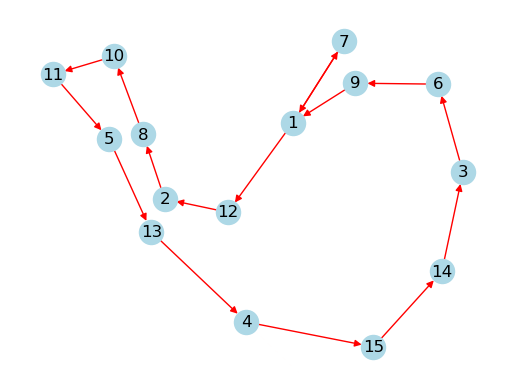

Ejecutando caso de prueba con datosTSP\cost_matrix_15_nodes_2.5_spread.csv...


In [6]:
# ejecutar el caso de prueba para k=1, k=2
def ejecutar_con_distintos_k(filename):
    for k in [1, 2]:
        cost_matrix = read_cost_matrix_csv(filename)
        print(f"--------------------Solución para k = {k}----------------------")
        Model, N, K= salesman(cost_matrix, k)
        plot_solution(Model, N, K)
    
for archivo in [ "datosTSP\cost_matrix_15_nodes_2.5_spread.csv"]:
    ejecutar_con_distintos_k(archivo)
    print(f'Ejecutando caso de prueba con {archivo}...') 

## Analisis de resultados
El problema se ejecutó con distintas configuraciones de cantidad de nodos (5, 10 y 15) y cantidad de equipos (1, 2, 3, 5). Cuando se trataron de cargar 20 nodos el modelo se volvió demasiado grande, y el solver no consigue una solución en un tiempo viable. 

- En el caso de 5 nodos, pasar de 1 a 2 equipos no redujo el costo total (de 16 a 18 unidades), pero con 3 equipos se logró una mayor optimización con un costo total de 21.

- Para 10 nodos, la configuración con 1 equipo tuvo un costo de 15, mientras que con 3 y 5 equipos los costos individuales variaron significativamente, sin evidenciar la anterior tendencia.

- En 15 nodos, la división en 2 equipos redujo el costo de 37 a 35, evidenciando que una partición adecuada puede disminuir los costos.